In [393]:
import pandas as pd
import os
import glob
import numpy as np
import pickle

import datetime as dt 
from datetime import datetime,timedelta

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from itertools import product, accumulate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from operator import add


In [ ]:
os.chdir('data-master')
os.chdir('csv')

In [ ]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
df = pd.DataFrame()
# Importing the data from coinmetrics and turning multiple folders into panel data
for name in csv_files:
    dfAdd = pd.read_csv(name)
    cols_to_keep = ["time","CapMrktEstUSD","ReferenceRate"]
    if set(cols_to_keep).issubset(dfAdd.columns):
        dfAdd.drop(dfAdd.columns.difference(cols_to_keep), axis=1, inplace=True)
        dfAdd.dropna(inplace=True)
        nameArray = name.split("/")
       
        dfAdd["time"] = pd.to_datetime(dfAdd["time"])
        dfAdd["day"]=dfAdd["time"].dt.day
        dfAdd['month'] = dfAdd['time'].dt.month
        dfAdd['year'] = dfAdd['time'].dt.year
        dfAdd["ret"] = dfAdd["ReferenceRate"].pct_change()
        dfAdd.dropna(inplace=True)
        dfAdd["coin"] = nameArray[len(nameArray)-1].split(".")[0]
        df = pd.concat([df,dfAdd], ignore_index = True)


In [ ]:
os.chdir("..")
# Reading the risk free rate
Rf = pd.read_csv("DGS10.csv")
Rf.loc[Rf["DGS10"]=='.',"DGS10"] = None
# Fill out the missing date since some data are missing by using previous nearest day value
Rf = Rf.ffill()

## Reversal Factor

In [ ]:
# This is the work for Appendix A
reversalTab = df.pivot_table(index='time',columns='coin',values='ret')
reversalTab = reversalTab+1

In [ ]:
dfRes= pd.DataFrame(index = reversalTab.index)

In [412]:
# Function to calculate return during the past period from daily return
def get_rolling_ret(data,n):
    return data.rolling(n).apply(np.prod)

# Get the winner (top 90% decile return) cryptocurrency
def get_top(date,dataH):
    top = dataH.loc[date].ge(dataH.loc[date].quantile(0.9))
    return top[top].index

# Return from holding the portfolio
def portfolio_ret(date,dataB, dataH,day):
    portfolio = dataB.loc[date:,get_top(date, dataH)][day:day+1]
    if len(portfolio)>0 :
        return portfolio.mean(axis=1).values[0]
    else:
        return None


# Function that takes everything together
def findMomentumRet(dayH, dayB, data,dataO):
    retH = get_rolling_ret(data, dayH)-1
    retB = get_rolling_ret(data, dayB)-1
    text = str(dayH)+"-"+str(dayB)
    dataO[text] = None
    for i in range(1,len(data)-1):
        dataO[text][i] = portfolio_ret(data.index[i],retH,retB,dayB)
    return dataO[text].dropna()

# Get the loser (low 10% decile return) cryptocurrency
def get_bot(date, dataH):
    bot = dataH.loc[date].le(dataH.loc[date].quantile(0.1))
    return bot[bot].index

# Return from buying the bottom cryptocurrency
# Need to manually invert the signs to mimic selling
def portfolio_retB(date,dataB, dataH,day):
    portfolio = dataB.loc[date:,get_bot(date, dataH)][day:day+1]
    if len(portfolio)>0 :
        return portfolio.mean(axis=1).values[0]
    else:
        return None
    
def findMomentumRetB(dayH, dayB, data,dataO):
    retH = get_rolling_ret(data, dayH)-1
    retB = get_rolling_ret(data, dayB)-1
    text = str(dayH)+"-"+str(dayB)+"S"
    dataO[text] = None
    for i in range(1,len(data)-1):
        dataO[text][i] = portfolio_retB(data.index[i],retH,retB,dayB)
    return dataO[text].dropna()

In [ ]:
days = [1, 7, 14, 21, 28]
for day in list(product(days, days)):
    findMomentumRetB(day[0],day[1],reversalTab,dfRes)
    findMomentumRet(day[0],day[1],reversalTab,dfRes)

In [ ]:
# For saving results
# with open('dfRes.pickle', 'wb') as handle:
#     pickle.dump(dfRes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# For reading the results back from the file
dfRes =pd.read_pickle('dfRes.pickle')


In [550]:
dfResRev = dfRes[(dfRes.index >= datetime(2021,10,1))].dropna()

In [551]:
# Calculaing the mean and significance
for i in dfResRev.columns:
    print("mean of " +i+ " : ")
    print(dfResRev[i].mean())
    print(stats.ttest_1samp(list(dfResRev[i]), popmean=0))
    pval = stats.ttest_1samp(list(dfResRev[i]), popmean=0)[1]
    if pval <0.01:
        print("***")
    elif pval < 0.05:
        print("**")
    elif pval < 0.1:
        print("*")
    print("-----")

mean of 1-1S : 
-0.001162333279862846
Ttest_1sampResult(statistic=-0.6479506799101408, pvalue=0.5172567207474352)
-----
mean of 1-1 : 
-0.005914911624938775
Ttest_1sampResult(statistic=-3.5490863252355367, pvalue=0.0004158191274952036)
***
-----
mean of 1-7S : 
-0.00034237172376089736
Ttest_1sampResult(statistic=-0.2018787943360325, pvalue=0.8400777001518094)
-----
mean of 1-7 : 
-0.0009942670273987203
Ttest_1sampResult(statistic=-0.5920338070875409, pvalue=0.5540437749285035)
-----
mean of 1-14S : 
-0.0006636459407751243
Ttest_1sampResult(statistic=-0.3883703968046061, pvalue=0.6978752679664431)
-----
mean of 1-14 : 
-0.0018454295097303237
Ttest_1sampResult(statistic=-1.158406620499831, pvalue=0.2471441438249185)
-----
mean of 1-21S : 
-0.0005386728652673883
Ttest_1sampResult(statistic=-0.31377497171404123, pvalue=0.7537974942302463)
-----
mean of 1-21 : 
-0.0019663171621899624
Ttest_1sampResult(statistic=-1.300239454172895, pvalue=0.19400204471996318)
-----
mean of 1-28S : 
-0.000154

In [552]:
# Buy-Sell portfolio
days = [1, 7, 14, 21, 28]
for day in list(product(days, days)):
    text = str(day[0])+"-"+str(day[1])
    print("mean of " +text+ " : ")
    bsPort = dfResRev[text]-dfResRev[text+"S"]
    print(bsPort.mean())
    print(stats.ttest_1samp(list(bsPort), popmean=0))
    pval = stats.ttest_1samp(list(bsPort), popmean=0)[1]
    if pval <0.01:
        print("***")
    elif pval < 0.05:
        print("**")
    elif pval < 0.1:
        print("*")
    print("-----")

mean of 1-1 : 
-0.00475257834507592
Ttest_1sampResult(statistic=-3.852040924605034, pvalue=0.0001293216309472022)
***
-----
mean of 1-7 : 
-0.0006518953036378232
Ttest_1sampResult(statistic=-0.6350837865600616, pvalue=0.5256080713854763)
-----
mean of 1-14 : 
-0.001181783568955198
Ttest_1sampResult(statistic=-1.3558072465874114, pvalue=0.17565412342489964)
-----
mean of 1-21 : 
-0.0014276442969225708
Ttest_1sampResult(statistic=-1.6315678203913013, pvalue=0.10327835848238005)
-----
mean of 1-28 : 
-0.001488366565269301
Ttest_1sampResult(statistic=-1.7256634623972533, pvalue=0.08490622562331405)
*
-----
mean of 7-1 : 
0.11736204229885647
Ttest_1sampResult(statistic=31.29013329001859, pvalue=1.1322843015280332e-129)
***
-----
mean of 7-7 : 
-0.0057281584552534666
Ttest_1sampResult(statistic=-2.18135005953657, pvalue=0.029532467104463472)
**
-----
mean of 7-14 : 
-0.003800248664179482
Ttest_1sampResult(statistic=-1.5310515830556086, pvalue=0.12626669574852384)
-----
mean of 7-21 : 
-0.004

## 5 size x5 ret Portfolio

In [553]:
# This is for Appendix B
dfC = df.copy()
dfC = dfC[dfC.time >= datetime(2021,1,1)]

In [554]:
# Sorting cryptocurrency based on prior return and size
dfC['Size'] =  dfC.groupby(['time'])['CapMrktEstUSD'].transform(lambda x: pd.qcut(x, 
                                                                                q =[0,0.2,0.4,0.6,0.8,1.0],
                                                                                labels=range(5,0,-1) ))
dfC["lag_Size"]= dfC.groupby(["coin"])["Size"].shift(1)
dfC["PriorRet"]= dfC.groupby(['time'])['ret'].transform(lambda x: pd.qcut(x, 
                                                                                q =[0,0.2,0.4,0.6,0.8,1.0],
                                                                                labels=range(5,0,-1) ))
dfC["lag_Ret"]=dfC.groupby(["coin"])["PriorRet"].shift(1)

In [555]:
dfC= dfC.dropna()
dfC

,time,CapMrktEstUSD,ReferenceRate,day,month,year,ret,coin,Size,lag_Size,PriorRet,lag_Ret
470,2021-01-02,2.247347e+08,0.032899,2,1,2021,0.032522,hbar,2,2,2,4
471,2021-01-03,2.250192e+08,0.033240,3,1,2021,0.010388,hbar,2,2,2,2
472,2021-01-04,2.192634e+08,0.033282,4,1,2021,0.001266,hbar,2,2,4,2
473,2021-01-05,2.516688e+08,0.032431,5,1,2021,-0.025579,hbar,2,2,4,4
474,2021-01-06,2.608629e+08,0.037224,6,1,2021,0.147792,hbar,2,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
388572,2023-07-07,6.300877e+09,0.664377,7,7,2023,-0.010196,matic,1,1,2,4
388573,2023-07-08,6.332496e+09,0.676098,8,7,2023,0.017642,matic,1,1,2,2
388574,2023-07-09,6.409747e+09,0.679491,9,7,2023,0.005018,matic,1,1,2,2
388575,2023-07-10,6.856403e+09,0.687780,10,7,2023,0.012199,matic,1,1,1,2


In [560]:
dfFiveFive = dfC.groupby(['time',"lag_Size","lag_Ret"])["ret"].mean().dropna().to_frame()

In [561]:
# Calculating mean pvalue and significance
for size in range(1,6):
    for ret in range(1,6):

        text = str(size)+"-"+str(ret)
        print("mean of " +text+ " : ")
        bsPort = dfFiveFive.loc[(slice(None),size,ret),:] ["ret"]
        print(bsPort.mean())
        print(stats.ttest_1samp(list(bsPort), popmean=0))
        pval = stats.ttest_1samp(list(bsPort), popmean=0)[1]
        if pval <0.01:
            print("***")
        elif pval < 0.05:
            print("**")
        elif pval < 0.1:
            print("*")
        print("-----")

mean of 1-1 : 
0.0036059308297002593
Ttest_1sampResult(statistic=2.276584273761358, pvalue=0.023040023805942462)
**
-----
mean of 1-2 : 
0.003084249429868197
Ttest_1sampResult(statistic=2.0590514768747346, pvalue=0.03977031731854737)
**
-----
mean of 1-3 : 
0.002096290478922891
Ttest_1sampResult(statistic=1.4410965606975614, pvalue=0.14989766392173878)
-----
mean of 1-4 : 
0.002114055345550404
Ttest_1sampResult(statistic=1.3736583193321106, pvalue=0.16988239928326704)
-----
mean of 1-5 : 
0.001213860711068645
Ttest_1sampResult(statistic=0.7270633582051108, pvalue=0.4673723075851457)
-----
mean of 2-1 : 
0.005128082651656862
Ttest_1sampResult(statistic=2.9463813612376004, pvalue=0.0032962587295527713)
***
-----
mean of 2-2 : 
0.003817625798866786
Ttest_1sampResult(statistic=2.3974326217587167, pvalue=0.016708930862110092)
**
-----
mean of 2-3 : 
0.0036575004992120443
Ttest_1sampResult(statistic=2.2265009782118725, pvalue=0.02622210321829768)
**
-----
mean of 2-4 : 
0.0019192156908711252

In [563]:

print("looping over ret")
for ret in range(1,6):
        a = dfFiveFive.loc[(slice(None),1,ret),:] ["ret"]
        b = dfFiveFive.loc[(slice(None),5,ret),:]["ret"]
        a = a[a.index.get_level_values('time').isin (b.index.get_level_values('time'))]
        b= b[b.index.get_level_values('time').isin (a.index.get_level_values('time'))]
        bsPort =np.subtract(b.values,a.values )

        print(np.mean(bsPort))
        print(stats.ttest_1samp(bsPort, popmean=0))
        pval = stats.ttest_1samp(bsPort, popmean=0)[1]
        if pval <0.01:
            print("***")
        elif pval < 0.05:
            print("**")
        elif pval < 0.1:
            print("*")
        print("-----")


 

looping over ret
-0.00902061027653227
Ttest_1sampResult(statistic=-6.742136493155097, pvalue=2.753023107543356e-11)
***
-----
-0.003589509291481604
Ttest_1sampResult(statistic=-3.6392797210687045, pvalue=0.0002886273390856036)
***
-----
0.00028976447360954413
Ttest_1sampResult(statistic=0.32281245924117097, pvalue=0.7469106267756302)
-----
0.000804269714103654
Ttest_1sampResult(statistic=0.9273342456460272, pvalue=0.3539962294900677)
-----
0.002286469331023666
Ttest_1sampResult(statistic=2.057721180788307, pvalue=0.0398985151776341)
**
-----


In [564]:

print("looping over size")
for size in range(1,6):
        a = dfFiveFive.loc[(slice(None),size,1),:] ["ret"]
        b = dfFiveFive.loc[(slice(None),size,5),:]["ret"]
        a = a[a.index.get_level_values('time').isin (b.index.get_level_values('time'))]
        b= b[b.index.get_level_values('time').isin (a.index.get_level_values('time'))]
        bsPort =np.subtract(b.values,a.values )

        print(np.mean(bsPort))
        print(stats.ttest_1samp(bsPort, popmean=0))
        pval = stats.ttest_1samp(bsPort, popmean=0)[1]
        if pval <0.01:
            print("***")
        elif pval < 0.05:
            print("**")
        elif pval < 0.1:
            print("*")
        print("-----")

looping over size
-0.002461073917299432
Ttest_1sampResult(statistic=-1.847452389705686, pvalue=0.06500283292693856)
*
-----
-0.00442187761931732
Ttest_1sampResult(statistic=-3.388314936015489, pvalue=0.0007330815248674089)
***
-----
0.0010253406889971833
Ttest_1sampResult(statistic=0.6748802067850558, pvalue=0.49992143950546175)
-----
0.0052499917183135006
Ttest_1sampResult(statistic=4.509103358943478, pvalue=7.350845004791282e-06)
***
-----
0.008836802609407826
Ttest_1sampResult(statistic=7.006297904487613, pvalue=4.725843762820308e-12)
***
-----


## Factor Formation

In [ ]:
# Forming the SMB and DMU factor for regression
dfD = df.copy()
dfD = dfD[dfD.time >= datetime(2021,1,1)]

In [ ]:
dfD['Size'] =  dfD.groupby(['time'])['CapMrktEstUSD'].transform(lambda x: pd.qcut(x, 
                                                                                q =[0,0.1,0.9,1.0],
                                                                                labels=[1,2,3] ))
dfD["lag_Size"]= dfD.groupby(["coin"])["Size"].shift(1)
dfD["PriorRet"]= dfD.groupby(['time'])['ret'].transform(lambda x: pd.qcut(x, 
                                                                                q =[0,0.3,0.7,1.0],
                                                                                labels=[1,2,3] ))
dfD["lag_Ret"]=dfD.groupby(["coin"])["PriorRet"].shift(1)

In [ ]:
dfSMB = dfD.groupby(['time',"lag_Size"])["ret"].mean().dropna().to_frame()
SMB = dfSMB.loc[(slice(None),1),:] ["ret"].sub(dfSMB.loc[(slice(None),3),:] ["ret"].reset_index(level=1, drop=True), axis = 0)

In [ ]:
dfDMU = dfD.groupby(['time',"lag_Ret"])["ret"].mean().dropna().to_frame()
DMU = dfDMU.loc[(slice(None),1),:] ["ret"].sub(dfDMU.loc[(slice(None),3),:] ["ret"].reset_index(level=1, drop=True), axis = 0)

## Factor Building

In [ ]:
def calcMarket(df):
    """
    Returns market return
    """
    totalReturn = df.CapMrktEstUSD.sum()
    return (df.ret*df.CapMrktEstUSD).sum() /totalReturn

In [ ]:
factors = pd.DataFrame(columns =
                  ["time",
                   "MktPrem"           
                  ])
factorsIndex = 0
for day in df.time.unique():
    factors.loc[factorsIndex] = [day,
                                 calcMarket( df.loc[df["time"]==day])
                                 ]
    factorsIndex+=1

In [ ]:
factors["time"]= pd.to_datetime(factors["time"])

In [ ]:
factorsUsed = factors[factors["time"]>"2021-01-01"]
factorsUsed["DMU"]= DMU.values
factorsUsed["SMB"]= SMB.values

In [ ]:
Rf.columns = ["time","Rf"]
Rf["time"] = pd.to_datetime(Rf["time"])

In [ ]:
factorsUsed.info()

In [ ]:
rhs = factorsUsed.join(Rf.set_index("time"),on="time").ffill().bfill()
rhs["Rf"] = pd.to_numeric(rhs["Rf"])
rhs["MktPrem"] = rhs["MktPrem"] - rhs["Rf"]
rhs.drop("Rf",inplace=True,axis=1)

In [ ]:
lhs = df[(df["coin"]=="ftt")& (df["time"]>="2021-01-01")][["time","ret"]].copy()
lhs["time"]= pd.to_datetime(lhs["time"])
lhs = lhs.merge(rhs,on="time")
lhs[["MktPrem","SMB","DMU"]]=lhs[["MktPrem","SMB","DMU"]].shift(1)
lhs = lhs.dropna()

In [ ]:
lhs

### Rolling window

In [566]:
r2_capm =[]
mse_capm=[]

r2_three =[]
mse_three =[]
advance = 20
for i in range(8): 
   start_day = datetime(2022,8,23)-  timedelta(days=7*i)+ timedelta(days=advance)
   end_day =datetime(2022,8,31)+ timedelta(days=advance)
   start_day_os = datetime(2022,9,1)+ timedelta(days=advance)
   end_day_os = datetime(2022,9,15)+ timedelta(days=advance)
   predicted_mkt = []
   predicted_three = []
   Y_os = lhs[(lhs["time"]>=start_day_os)&(lhs["time"]<=end_day_os)][["ret"]]

   while start_day_os <= end_day_os:
      # CAPM Model
      ## Linear
      X_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["MktPrem"]]
      Y_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["ret"]]
      mktModel = LinearRegression().fit(X_is,Y_is )

      X_os = lhs[(lhs["time"]==start_day_os)][["MktPrem"]]

      ## Random Forest
      mktModel_RF = RandomForestRegressor(max_depth=2, random_state=0)
      mktModel_RF.fit(X_is, Y_is)

      ##Support Vector
      sc_X = StandardScaler()
      X_fit_is = sc_X.fit_transform(X_is)
      X_fit_os = sc_X.transform(X_os)
      mktModel_SV = SVR(kernel = 'rbf')
      mktModel_SV.fit(X_fit_is, Y_is["ret"])

      predicted_mkt.append((mktModel.predict(X_os)[0][0],
                           mktModel_RF.predict(X_os)[0],
                           mktModel_SV.predict(X_os)[0]
                              ))

      # Factor Model
      ## Linear
      XThree_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["MktPrem","SMB","DMU"]]
      factorModel = LinearRegression().fit(XThree_is,Y_is )
      XThree_os = lhs[(lhs["time"]==start_day_os)][["MktPrem","SMB","DMU"]]

      ## Random Forest
      factorModel_RF = RandomForestRegressor(max_depth=2, random_state=0)
      factorModel_RF.fit(XThree_is, Y_is)

      ##Support Vector
      sc_X = StandardScaler()
      X_fit_is = sc_X.fit_transform(XThree_is)
      X_fit_os = sc_X.transform(XThree_is)
      factorModel_SV = SVR(kernel = 'rbf')
      factorModel_SV.fit(XThree_is, Y_is["ret"])

      predicted_three.append((factorModel.predict(XThree_os)[0][0],
                           factorModel_RF.predict(XThree_os)[0],
                           factorModel_SV.predict(XThree_os)[0]
                              ))


      start_day = start_day + timedelta(days=1)
      end_day = end_day + timedelta(days=1)
      start_day_os = start_day_os + timedelta(days=1)
   a=[r2_score(Y_os, list(map(lambda x: x[j], predicted_mkt))) for j in range(3)]
   a.append(
      r2_score(Y_os, list(map(lambda x: (x[0]+x[1]+x[2])/3, predicted_mkt)))
   )
   r2_capm.append(a)
   b=[mean_squared_error(Y_os, list(map(lambda x: x[j], predicted_mkt))) for j in range(3)]
   b.append(
      mean_squared_error(Y_os, list(map(lambda x: (x[0]+x[1]+x[2])/3, predicted_mkt)))
   )
   mse_capm.append(b)

   a=[r2_score(Y_os, list(map(lambda x: x[j], predicted_three))) for j in range(3)]
   a.append(
      r2_score(Y_os, list(map(lambda x: (x[0]+x[1]+x[2])/3, predicted_three)))
   )
   r2_three.append(a)
   b=[mean_squared_error(Y_os, list(map(lambda x: x[j], predicted_three))) for j in range(3)]
   b.append(
      mean_squared_error(Y_os, list(map(lambda x: (x[0]+x[1]+x[2])/3, predicted_three)))
   )
   mse_three.append(b)


In [349]:
pd.DataFrame(mse_capm).transpose()


,0,1,2,3,4,5,6,7
0,0.000661,0.000841,0.000624,0.000570,0.000537,0.000515,0.000519,0.000550
1,0.000848,0.000721,0.000636,0.000626,0.000527,0.000592,0.000591,0.000571
2,0.000544,0.000829,0.001121,0.000792,0.000641,0.000850,0.000981,0.000917
3,0.000455,0.000614,0.000637,0.000577,0.000513,0.000546,0.000581,0.000581


In [350]:
# For exporting results
pd.DataFrame(mse_three).transpose()

,0,1,2,3,4,5,6,7
0,0.001272,0.000971,0.000620,0.000557,0.000648,0.000659,0.000677,0.000634
1,0.000481,0.000532,0.000384,0.000441,0.000522,0.000452,0.000515,0.000487
2,0.000544,0.000829,0.001121,0.000792,0.000641,0.000850,0.000981,0.001357
3,0.000419,0.000643,0.000577,0.000512,0.000568,0.000591,0.000659,0.000708


In [351]:
pd.DataFrame(r2_capm).transpose()


,0,1,2,3,4,5,6,7
0,-0.441891,-0.834956,-0.360337,-0.244336,-0.171354,-0.122973,-0.132033,-0.200591
1,-0.850073,-0.571754,-0.387373,-0.364611,-0.149490,-0.291398,-0.288386,-0.244974
2,-0.186733,-0.808346,-1.444551,-0.726913,-0.397716,-0.854792,-1.139717,-1.000828
3,0.007981,-0.339381,-0.389796,-0.259490,-0.118467,-0.189827,-0.267130,-0.267668


In [352]:
# For exporting results
pd.DataFrame(r2_three).transpose()


,0,1,2,3,4,5,6,7
0,-1.774148,-1.117005,-0.352512,-0.214692,-0.414473,-0.436416,-0.476042,-0.381848
1,-0.049225,-0.159973,0.163063,0.038389,-0.137938,0.013296,-0.122938,-0.062771
2,-0.186733,-0.808346,-1.444551,-0.726913,-0.397716,-0.854792,-1.139717,-1.959943
3,0.085183,-0.401673,-0.258943,-0.115790,-0.238358,-0.289517,-0.436550,-0.544924


### No Rolling

In [341]:
r2_capm_noRoll =[]
mse_capm_noRoll=[]

r2_three_noRoll =[]
mse_three_noRoll =[]
for i in range(8): 
   start_day = datetime(2022,8,23)-  timedelta(days=7*i)+ timedelta(days=advance)
   end_day =datetime(2022,8,31)+ timedelta(days=advance)
   start_day_os = datetime(2022,9,1)+ timedelta(days=advance)
   end_day_os = datetime(2022,9,15)+ timedelta(days=advance)

   # CAPM Model
   ## Linear
   X_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["MktPrem"]]
   Y_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["ret"]]
   mktModel = LinearRegression().fit(X_is,Y_is )

   X_os = lhs[(lhs["time"]>=start_day_os)&(lhs["time"]<=end_day_os)][["MktPrem"]]
   Y_os = lhs[(lhs["time"]>=start_day_os)&(lhs["time"]<=end_day_os)][["ret"]]

   ## Random Forest
   mktModel_RF = RandomForestRegressor(max_depth=2, random_state=0)
   mktModel_RF.fit(X_is, Y_is)

   ##Support Vector
   sc_X = StandardScaler()
   X_fit_is = sc_X.fit_transform(X_is)
   X_fit_os = sc_X.transform(X_os)
   mktModel_SV = SVR(kernel = 'rbf')
   mktModel_SV.fit(X_fit_is, Y_is["ret"])

   mktModel_Total = np.mean( np.array([ [item[0] for item in mktModel.predict(X_os)],
      mktModel_RF.predict(X_os),
      mktModel_SV.predict(X_os)]), axis=0 )


   r2_capm_noRoll.append([
      r2_score(Y_os,[item[0] for item in mktModel.predict(X_os)]),
      r2_score(Y_os, mktModel_RF.predict(X_os)),
      r2_score(Y_os, mktModel_SV.predict(X_os)),
      r2_score(Y_os, mktModel_Total)
      ])

   mse_capm_noRoll.append([
      mean_squared_error(Y_os, [item[0] for item in mktModel.predict(X_os)]),
      mean_squared_error(Y_os, mktModel_RF.predict(X_os)),
      mean_squared_error(Y_os, mktModel_SV.predict(X_os)),
      mean_squared_error(Y_os, mktModel_Total)
      ])
   # Factor Model
   ## Linear
   XThree_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["MktPrem","SMB","DMU"]]
   factorModel = LinearRegression().fit(XThree_is,Y_is )
   XThree_os = lhs[(lhs["time"]>=start_day_os)&(lhs["time"]<=end_day_os)][["MktPrem","SMB","DMU"]]

   ## Random Forest
   factorModel_RF = RandomForestRegressor(max_depth=2, random_state=0)
   factorModel_RF.fit(XThree_is, Y_is)

   ##Support Vector
   sc_X = StandardScaler()
   X_fit_is = sc_X.fit_transform(XThree_is)
   X_fit_os = sc_X.transform(XThree_is)
   factorModel_SV = SVR(kernel = 'rbf')
   factorModel_SV.fit(XThree_is, Y_is["ret"])
   
   factorModel_Total = np.mean( np.array([ [item[0] for item in factorModel.predict(XThree_os)],
      factorModel_RF.predict(XThree_os),
      factorModel_SV.predict(XThree_os) ]), axis=0 )

   r2_three_noRoll.append([
      r2_score(Y_os, [item[0] for item in factorModel.predict(XThree_os)]),
      r2_score(Y_os, factorModel_RF.predict(XThree_os)),
      r2_score(Y_os, factorModel_SV.predict(XThree_os)),
      r2_score(Y_os, factorModel_Total)
      ])

   mse_three_noRoll.append([
      mean_squared_error(Y_os, [item[0] for item in factorModel.predict(XThree_os)]),
      mean_squared_error(Y_os, factorModel_RF.predict(XThree_os)),
      mean_squared_error(Y_os, factorModel_SV.predict(XThree_os)),
      mean_squared_error(Y_os, factorModel_Total)
      ])


In [342]:
pd.DataFrame(r2_capm_noRoll).transpose()

,0,1,2,3,4,5,6,7
0,-0.503810,-2.597722,-1.076434,-0.508162,-0.007233,-0.194137,-0.192409,-0.471491
1,-0.384379,-0.231876,-0.145830,-0.050622,-0.000159,-0.013992,-0.004859,-0.000346
2,-2.077113,-1.255575,-0.193666,-0.193666,-1.139717,-1.139717,-1.139717,-0.394178
3,0.027829,-0.580634,-0.149107,-0.102281,-0.163255,-0.214433,-0.228951,-0.199931


In [343]:
pd.DataFrame(r2_three_noRoll).transpose()


,0,1,2,3,4,5,6,7
0,-0.590179,-4.962721,-3.617291,-1.867836,-1.045212,-1.470229,-0.582584,-0.583704
1,0.054762,0.181742,-0.025486,-0.167877,-0.288716,-0.052912,-0.150882,-0.084191
2,-2.077113,-1.255575,-0.193666,-0.193666,-1.139717,-1.139717,-1.139717,-5.261448
3,-0.223440,-1.350505,-0.761795,-0.534348,-0.725619,-0.744629,-0.552359,-1.318651


In [344]:
pd.DataFrame(mse_capm_noRoll).transpose()

,0,1,2,3,4,5,6,7
0,0.000689,0.001649,0.000952,0.000691,0.000462,0.000547,0.000547,0.000675
1,0.000635,0.000565,0.000525,0.000482,0.000459,0.000465,0.000461,0.000459
2,0.001411,0.001034,0.000547,0.000547,0.000981,0.000981,0.000981,0.000639
3,0.000446,0.000725,0.000527,0.000505,0.000533,0.000557,0.000563,0.000550


In [345]:
pd.DataFrame(mse_three_noRoll).transpose()

,0,1,2,3,4,5,6,7
0,0.000729,0.002734,0.002117,0.001315,0.000938,0.001133,0.000726,0.000726
1,0.000433,0.000375,0.000470,0.000535,0.000591,0.000483,0.000528,0.000497
2,0.001411,0.001034,0.000547,0.000547,0.000981,0.000981,0.000981,0.002871
3,0.000561,0.001078,0.000808,0.000703,0.000791,0.000800,0.000712,0.001063


In [346]:
#For exporting results
#pd.DataFrame(mse_three_noRoll).transpose()


## Event study

Using the best model which is 8 weeks-rolling period- three factor- random forest

In [355]:
estimation_start_day = datetime(2022,11,4)+ timedelta(days=-1) -  timedelta(days=7*8)
estimation_end_day =datetime(2022,11,4)+ timedelta(days=-1)

prediction_start_day = datetime(2022,11,4)
prediction_end_day = datetime(2022,11,18)

In [358]:
event_predict = []
start_day = estimation_start_day
end_day = estimation_end_day
start_day_os = prediction_start_day
end_day_os = prediction_end_day
while start_day_os <= end_day_os:

    Y_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["ret"]]

    # Factor Model
    ## Linear
    XThree_is = lhs[(lhs["time"]>=start_day)&(lhs["time"]<=end_day)][["MktPrem","SMB","DMU"]]
    ## Random Forest
    factorModel_RF = RandomForestRegressor(max_depth=2, random_state=0)
    factorModel_RF.fit(XThree_is, Y_is)

    XThree_os = lhs[(lhs["time"]==start_day_os)][["MktPrem","SMB","DMU"]]

    event_predict.append(
                        factorModel_RF.predict(XThree_os)[0]
                            )


    start_day = start_day + timedelta(days=1)
    end_day = end_day + timedelta(days=1)
    start_day_os = start_day_os + timedelta(days=1)

In [401]:
real_ret = lhs[(lhs["time"]>=prediction_start_day)&(lhs["time"]<=prediction_end_day)][["ret"]]["ret"].values
date = lhs[(lhs["time"]>=prediction_start_day)&(lhs["time"]<=prediction_end_day)][["time"]]["time"].values
event_date = datetime(2022,11,11)

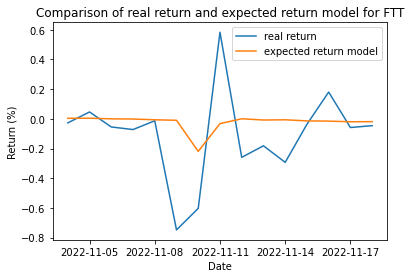

In [389]:
plt.plot(date, real_ret, label = "real return")
plt.plot(date, event_predict, label = "expected return model")
plt.title("Comparison of real return and expected return model for FTT")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 3))
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()

Text(0, 0.5, 'Return (%)')

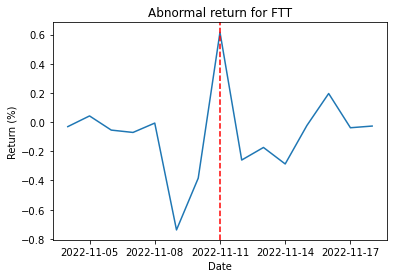

In [405]:
abnormalRet= np.subtract(real_ret,event_predict )
plt.plot(date, ab_ret)
plt.title("Abnormal return for FTT")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 3))
plt.axvline( event_date,linestyle= "--",color="r") 
plt.xlabel("Date")
plt.ylabel("Return (%)")


Text(0, 0.5, 'Return (%)')

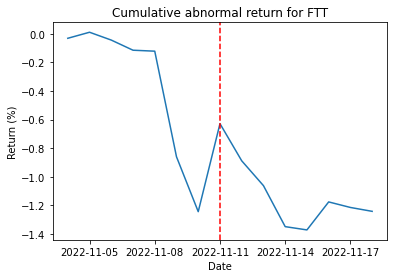

In [565]:
accumulate_abnormalRet = list(accumulate(abnormalRet, func=add))
plt.plot(date, accumulate_abnormalRet)
plt.title("Cumulative abnormal return for FTT")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 3))
plt.axvline( event_date,linestyle= "--",color="r") 
plt.xlabel("Date")
plt.ylabel("Return (%)")